## Lokalizacja punktu w przestrzeni dwuwymiarowej metodą trapezową

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer
from math import inf
from enum import Enum
import random
import time

## Wprowadzenie

Niech $S$ będzie podziałem przestrzeni dwuwymiarowej zawierającym $n$ krawędzi.
Zadaniem algorytmu *lokalizacji punktu w przestrzeni* jest znalezienie takiej
ściany $f \in S$, w której znajduje się zadany punkt $q$.
W przypadku gdy: 
 - $q$ nie leży wewnątrz żadnej ściany,
 - $q$ znajduje się na krawędzi,
 - $q$ jest jednym z wierzchołków

algorytm powinien zwrócić odpowiednią informację.

### Metoda trapezowa

Jeden z algorytmów rozwiązujących problem *lokalizacji punktu w przestrzeni*
nosi nazwę *podziału trapezowego przestrzeni* i polega na doskonaleniu podziału
przestrzeni poprzez "wystrzeliwanie" pionowych odcinków, kończących się 
na pierwszej spotkanej krawędzi, z każdego wierzchołka. Otrzymujemy wtedy podział
przestrzeni zawierający $O(n)$ (jest to wartość oczekiwana!) krawędzi i wierzchołków.

W trakcie budowy podziału trapezowego, który będziemy nazywać *mapą trapezową*,
konstruujemy także strukturę pozwalającą nam na znalezienie trapezu, w którym
zawiera się zadany punkt $q$, w oczekiwanym czasie $O(logn)$. 
Strukturę tą będziemy nazywać *grafem przeszukiwań*.

Podsumowując, algorytm dla danego podziału przestrzeni $S$ zwraca mapę trapezową
$T(S)$ oraz graf przeszukiwań $D$. Oczekiwany czas działania algorytmu to $O(nlogn)$.
Dalej znajduje się dokładny opis i implementacja algorytmu.

## Funkcje pomocnicze

In [5]:
# > 0 jeżeli układ punktów a->b->c tworzy skręt w lewo
def orient(a, b, c):
    return (
        a[0]*b[1]
        + b[0]*c[1]
        + a[1]*c[0]
        - b[1]*c[0]
        - c[1]*a[0]
        - a[1]*b[0]
    )

# zwraca prostą zawierającą odcinek (w postaci kierunkowej)
def section_to_line(s):
    (x1, y1), (x2, y2) = s
    
    a = (y1 - y2)/(x1 - x2)
    b = y1 - x1 * a
    return a, b

# Zwraca wartość:
# >0 - gdy punkt a jest po lewej od b (leksykograficznie)
# 0  - gdy a jest równe b
# <0  - inaczej
def point_cmp(a, b):
    if a[0] < b[0] or (a[0] == b[0] and a[1] < b[1]):
        return 1
    elif a[0] == b[0] and a[1] == b[1]:
        return 0
    else: 
        return -1
    
# Zwraca wartość:
# >0 - gdy punkt p znajduje się nad section
# 0  - gdy punkt p znajduje się na section
# <0 - inaczej
def section_cmp(section, p):
    return orient(section[0], section[1], p)

# Wejściem programu jest lista odcinków,
# więc żeby do ich wierzchołków odwoływać
# się po indeksie przyjmuję że końce odcinka
# o indeksie i mają indeksy 2i oraz 2i + 1.
# Poniższe funkcje pomagają w zapisie i odczycie
# końców odcinków.  
def section_idx_to_coords_idxs(i):
    return 2*i, 2*i + 1
def point_from_coord_idx(i, sections):
    return sections[i // 2][i % 2]
    

## Implementacja mapy trapezowej i grafu przeszukiwań 

### Struktura danych:
Podział przestrzeni $S_n$ reprezentowany jest jako lista odcinków $S_n = (s_1, s_2, ..., s_n)$
spełniających poniższe założenia:
 1. Odcinki mogą przecinać się jedynie na wierzchołkach.
 2. Wierzchołki mają parami różne współrzędne $x$.

Lista $S_n$ spełniająca powyższe założenia jest w *położeniu ogólnym*.

Jesteśmy w stanie pozbyć się założenia 2 poprzez *przekształcenie ścinające* 
odcinków w $S_n$ o dostatecznie mały kąt $\varphi$ i stworzenie mapy trapezowej dla
tak powstałej listy $\varphi S_n$. Okazuje się jednak<sup>1</sup>, że przekształcenie to
może pozostać jedynie w domyśle i wystarczy porównywać punkty leksykograficznie, przy sprawdzaniu
ich względnego położenia na osi $OX$.

### Struktura wynikowa:
Mapa trapezowa $T(S_n)$ oraz graf przeszukiwań $D$, które będziemy oznaczać
od teraz łącznie jako $T(S_n)$, reprezentowane są przez strukturę `TrapezoidMap`. 
Po stworzeniu reprezentuje ona mapę $T(\emptyset)$ (oznaczamy ją także jako $T(S_0)$), 
zawierającą jedynie prostokąt, wewnątrz którego zawiera się każdy odcinek z $S_n$. 
Przy użyciu metody `advance_i` dodajemy do mapy kolejny odcinek z $S$ zamieniając
ją na mapę $T(S_i)$ (gdzie $S_i = (s_1,s_2, ..., s_i)$). Zatem, aby
otrzymać pełną strukturę $T(S_n)$ należy wywołać `advance_i` $n$ razy.

Wewnątrz `TrapezoidMap` znajdują się 3 najważniejsze struktury:
 1. `TrapezoidNode` - Reprezentuje liść w grafie przeszukiwań, zawiera reprezentację
danego trapezu, wskaźniki do jego sąsiadów (max. czterech) i wskaźniki do wszystkich
węzłów rodziców w grafie przeszukiwań.
 1. `XNode` - Reprezentuje węzeł sprawdzający czy dany punkt znajduje się po lewo
od trzymanego w węźle punktu. Ma wskaźniki do dwojga dzieci: `left` i `right`. 
Jeżeli dany punkt znajduje się po lewo, `XNode` poprowadzi nas do `left`, a gdy po prawo
to do `right`.
 1. `YNode` - Reprezentuje węzeł sprawdzający czy dany punkt znajduje się nad trzymanym
w węźle odcinkiem. Działa analogicznie do `XNode`, prowadząc do `left` gdy punkt znajduje
się ponad lub do `right` gdy znajduje się pod.

Metoda `find` odpowiada na zapytanie lokalizacji punktu `q` w mapie.
Zwraca ona węzeł, w którym znajdziemy `q`. Jeżeli `q` jest jednym z wierzchołków
w mapie, bądź znajduje się na jednym z odcinków, metoda ta zwraca odpowiedni `XNode`
lub `YNode`, w przeciwnym przypadku zwrócony jest zawsze odpowiadający `TrapezoidNode`.

Trapezy trzymane w `TrapezoidMap` reprezentowane są przez strukturę `Trapezoid`,
która zawiera <ins>indeksy</ins> odcinków definiujących dany trapez z góry i z dołu (`top` i `bottom`)
oraz <ins>indeksy</ins> wierzchołków definiujących trapez z lewej i z prawej (`leftp` i `rightp`).

In [71]:
# Struktura jednoznacznie
# reprezentująca trapez.
# Odcinki top i bottom 
# oraz punkty leftp i rightp
# są trzymane jako ich indeksy.
class Trapezoid:
    def __init__(self, top, bottom, leftp, rightp):
        self.top = top
        self.bottom = bottom
        self.leftp = leftp
        self.rightp = rightp
    
    # Zwraca wierzchołki trapezu.
    def as_verticies(self, sections):
        a, b = section_to_line(sections[self.top])
        c, d = section_to_line(sections[self.bottom])
        
        x1 = point_from_coord_idx(self.leftp, sections)[0]
        x2 = point_from_coord_idx(self.rightp, sections)[0]
        
        ll = (x1, c * x1 + d)
        lu = (x1, a * x1 + b)
        rl = (x2, c * x2 + d)
        ru = (x2, a * x2 + b)
        return [ll, rl, ru, lu]

# Struktura reprezentująca dowolny
# węzeł w grafie przeszukiwań.
# Ma wskaźniki do lewego i prawego potomka.
class Node:
    def __init__(self):
        self.left = None
        self.right = None
    def follow(self, p, sections):
        return self.left

# Struktura reprezentująca liść (trapez)
# w grafie przeszukiwań.
# Oprócz Trapezu zawiera także wskaźniki
# do jego sąsiadów w reprezentacji.
# UWAGA: Jeżeli trapez ma tylko jednego
# sąsiada z jakiejś strony to jest on
# zawsze *_lower.
class TrapezoidNode(Node):
    def __init__(self, trapezoid, parents):
        self.trapezoid = trapezoid
        self.left_lower = None
        self.left_upper = None
        self.right_lower = None
        self.right_upper = None
        
        self.parents = parents
    def follow(self, p, cmp):
        return None

# Struktura reprezentująca węzeł
# końca odcinka.
class XNode(Node):
    def __init__(self, x):
        self.x = x
        Node.__init__(self)
    
    # Zwraca lewego potomka, jeżeli
    # p znajduje się po lewo od trzymanego punktu
    # lub prawego gdy znajduje się po prawej.
    # Gdy p jest równy trzymanemu punktowi, zwraca None.
    def follow(self, p, sections):
        cmp = point_cmp(p, point_from_coord_idx(self.x, sections))
        if cmp  > 0:
            return self.left
        elif cmp == 0:
            return None
        else:
            return self.right

# Struktura reprezentująca węzeł
# odcinka.
class YNode(Node):
    def __init__(self, edge):
        self.edge = edge
        Node.__init__(self)

    # Zwraca lewego potomka gdy p znajduje się 
    # nad odcinkiem lub prawego gdy znajduje się pod.
    # Gdy p jest na odcinku, zwraca None.
    def follow(self, p, sections):
        cmp = section_cmp(sections[self.edge], p)
        if cmp > 0:
            return self.left
        elif cmp == 0:
            return None
        else:
            return self.right

# Struktura reprezentująca mapę trapezową T(S_i) 
# oraz odpowiadający jej graf przeszukiwań
# dla danego zbioru odcinków S.
# Jest to DAG przypominający strukturą drzewo binarne,
# lecz liście zawierające trapezy zawierają także wskaźniki
# do sąsiednich w mapie trapezów.
#
# Odcinki i punkty w strukturze przetrzymywane są
# po indeksach odnoszących się do przekazanej w konstruktorze
# listy odcinków.
class TrapezoidalMap:
    def __init__(self, sections):
        self.sections = sections
        self.i = None
        self.n = len(sections)
        
        # Pusty wartownik jako root prowadzi do bounding_box
        self.root = Node()
        self.root.left = TrapezoidNode(
            self.create_bouding_box(), 
            [self.root]
        )
    
    # Zwraca listę wszystkich trapezów w mapie.
    def get_trapezoids(self):
        stack = [self.root]
        
        res = set()
        while len(stack) != 0:
            nod = stack.pop()
            if nod is None: continue
            if isinstance(nod, TrapezoidNode):
                res.add(nod.trapezoid)
                continue
            
            stack.append(nod.left)
            stack.append(nod.right)
        return list(res)
    
    # Tworzy trapez będący prostokątem
    # wewnątrz, którego zawierają się
    # wszystkie odcinki.
    def create_bouding_box(self, off=1):
        minx = miny = inf
        maxx = maxy = -inf
        for sect in self.sections:
            for pt in sect:
                if pt[0] < minx:
                    minx = pt[0]
                if pt[0] > maxx:
                    maxx = pt[0]
                
                if pt[1] < miny:
                    miny = pt[1]
                if pt[1] > maxy:
                    maxy = pt[1]

        # FIXME: Nie jest to jakieś
        # eleganckie ale działa.
        mx = (maxx + off, maxy + off)
        mn = (minx - off, miny - off)
        
        top = [(mn[0], mx[1]), mx]
        bot = [mn, (mx[0], mn[1])]
        
        self.sections.append(top)
        self.sections.append(bot)
        
        _, mxi = section_idx_to_coords_idxs(self.n)
        mni, _ = section_idx_to_coords_idxs(self.n + 1)
        
        return Trapezoid(self.n, self.n + 1, mni, mxi)
    
    # Zwraca węzeł zawierający p.
    # UWAGA: Gdy p jest końcem jakiegoś
    # odcinka, lub leży na odcinku, 
    # zwrócony zostanie odpowiadający
    # XNode lub YNode.
    def find(self, p):
        curr = self.root
        while True:
            nxt = curr.follow(p, self.sections)
            if nxt == None: break
            curr = nxt
        return curr

    # Zwraca trapez odpowiadający p.
    # Gdy p jest końcem jakiegoś odcinka,
    # zwraca trapez po prawo od niego, 
    # a gdy p leży na odcinku, to zwraca
    # trapez pod nim.
    def find_trapezoid(self, p):
        curr = self.root
        while True:
            nxt = curr.follow(p, self.sections)
            if nxt == None:
                if not isinstance(curr, TrapezoidNode):
                    curr = curr.right
                else: break
            else:
                curr = nxt
        return curr

    # Zamienia T(S_i) na T(S_(i + 1))
    # (dodaje kolejny na liście odcinek do mapy).
    # Nic nie robi gdy i jest równe n.
    def advance_i(self):
        if self.i is None:
            self.i = 0
        else:
            self.i += 1
        
        if self.i == self.n: return
        
        zone, is_p_in_map, is_q_in_map = self.find_section_zone(self.i)
        self.partition_zone(zone, self.i, is_p_in_map, is_q_in_map)
    
    # Znajduje listę trapezów przeciętych przez odcinek
    # o indeksie i.
    def find_section_zone(self, i):
        sect = self.sections[i]
        p = sect[0]
        q = sect[1]
        
        is_p_in_map = False
        is_q_in_map = False
        
        zone0 = self.find_trapezoid(p)
        if zone0 != self.find(p):
            is_p_in_map == True
        zone = [zone0]
        curr_rightp = point_from_coord_idx(zone[-1].trapezoid.rightp, self.sections)
        # while q is to the right of current rightp
        while point_cmp(curr_rightp, q) > 0:
            # if current rightp is above sect 
            if zone[-1].right_upper is None or section_cmp(sect, curr_rightp) > 0:
                zone.append(zone[-1].right_lower)
            else:
                zone.append(zone[-1].right_upper)
            curr_rightp = point_from_coord_idx(zone[-1].trapezoid.rightp, self.sections)
        
        if self.find(q) != zone[-1]:
            is_q_in_map = True
        return zone, is_p_in_map, is_q_in_map
    
    # Tworzy nowe trapezy i odpowiednio skraca
    # pionowe przedłużenia wierzchołków dla
    # trapezów w liście zone, będącej zbiorem
    # trapezów przeciętych przez odcinek o indeksie i.
    def partition_zone(self, zone, i, is_p_in_map, is_q_in_map):
        # niemożliwy jest przypadek gdy len(zone) == 1 && is_p_in_map && is_q_in_map
        if len(zone) == 1 and not is_p_in_map and not is_q_in_map:
            self.partition_one(zone[0], i)
        elif len(zone) == 1 and is_p_in_map:
            self.partition_one_tri_left(zone[0], i)
        elif len(zone) == 1 and is_q_in_map:
            self.partition_one_tri_right(zone[0], i)
        elif len(zone) > 1:
            self.partition_mult(zone, i, is_p_in_map, is_q_in_map)
    
    # partition_zone ale w przypadku, gdy
    # odcinek zawiera się całkowicie w jednym
    # trapezie.
    def partition_one(self, zone_node, i):
        zone_trap = zone_node.trapezoid
        p, q = section_idx_to_coords_idxs(i)
            
        # tworzenie nowego poddrzewa w strukturze
        sub = XNode(p)
        self.replace_node(zone_node, sub)
        
        sub.right = XNode(q)
        sub.right.left = YNode(i)
        
        # tworzenie liści
        a = TrapezoidNode(Trapezoid(
            zone_trap.top,
            zone_trap.bottom,
            zone_trap.leftp,
            p
        ), [sub])
        sub.left = a
        
        c = TrapezoidNode(Trapezoid(
            zone_trap.top,
            i,
            p,
            q
        ), [sub.right.left])
        sub.right.left.left = c
        
        d = TrapezoidNode(Trapezoid(
            i,
            zone_trap.bottom,
            p,
            q
        ), [sub.right.left])
        sub.right.left.right = d
        
        b = TrapezoidNode(Trapezoid(
            zone_trap.top,
            zone_trap.bottom,
            q,
            zone_trap.rightp,
        ), [sub.right])
        sub.right.right = b
        
        # poprawianie sasiadow
        a.right_lower = d
        a.right_upper = c
        
        c.left_lower = a
        c.right_lower = b
        
        d.left_lower = a
        d.right_lower = b
        
        b.left_lower = d
        b.left_upper = c

        self.replace_trap_node_left(zone_node, a)
        self.replace_trap_node_right(zone_node, b)
    
        del zone_node
    
    # partition_one ale w przypadku, gdy 
    # lewy koniec odcinka jest już wierzchołkiem
    # w mapie
    def partition_one_tri_left(self, zone_node, i):
        zone_trap = zone_node.trapezoid
        p, q = section_idx_to_coords_idxs(i)
        
        sub = XNode(q)
        sub.left = YNode(i)
        
        self.replace_node(zone_node, sub)
        
        upp = TrapezoidNode(Trapezoid(
            zone_trap.top,
            i,
            p,
            q
        ), [sub.left])
        sub.left.left = upp
        
        low = TrapezoidNode(Trapezoid(
            i,
            zone_trap.bottom,
            p,
            q
        ), [sub.left])
        sub.left.right = low
        
        a = TrapezoidNode(Trapezoid(
            zone_trap.top,
            zone_trap.bottom,
            q,
            zone_trap.rightp
        ), [sub])
        sub.right = a
        
        a.left_lower = low
        low.right_lower = a
        a.left_upper = upp
        upp.right_lower = a
        
        self.replace_trap_node_right(zone_node, a)
        self.replace_trap_node_left(zone_node, upp)
        del zone_node
    
    # partition_one ale w przypadku, gdy 
    # prawy koniec odcinka jest już wierzchołkiem
    # w mapie
    def partition_one_tri_right(self, zone_node, i):
        zone_trap = zone_node.trapezoid
        p, q = section_idx_to_coords_idxs(i)
        
        sub = XNode(q)
        sub.right = YNode(i)
        
        self.replace_node(zone_node, sub)
        
        upp = TrapezoidNode(Trapezoid(
            zone_trap.top,
            i,
            p,
            q
        ), [sub.right])
        sub.right.left = upp
        
        low = TrapezoidNode(Trapezoid(
            i,
            zone_trap.bottom,
            p,
            q
        ), [sub.right])
        sub.right.right = low
        
        a = TrapezoidNode(Trapezoid(
            zone_trap.top,
            zone_trap.bottom,
            zone_trap.leftp,
            p
        ), [sub])
        sub.left = a
        
        a.right_lower = low
        low.left_lower = a
        a.right_upper = upp
        upp.left_lower = a
        
        self.replace_trap_node_left(zone_node, a)
        self.replace_trap_node_right(zone_node, upp)
        del zone_node
    
    # partition_zone, ale w przypadku, gdy
    # odcinek przecina kilka trapezów
    def partition_mult(self, zone, i, is_p_in_map, is_q_in_map):
        # Enum dla stanu głównej pętli.
        class ToMerge(Enum):
            UPP = 1
            LOW = 2
        
        k = len(zone)
        
        # początek i koniec odcinka
        p, q = section_idx_to_coords_idxs(i)
        
        zone0 = zone[0]
        zone0_trap = zone0.trapezoid
        
        yn = YNode(i)
        # górny i dolny trapez na początku, rightp jest jeszcze nieznane
        upp = TrapezoidNode(Trapezoid(
            zone0_trap.top,
            i,
            p,
            None
        ), [yn])
        
        low = TrapezoidNode(Trapezoid(
            i,
            zone0_trap.bottom,
            p,
            None
        ), [yn])
        
        # dołączenia w grafie przeszukiwań
        yn.left = upp
        yn.right = low
        
        # tworzymy lewy trapez jeżeli trzeba
        if not is_p_in_map:
            xn = XNode(p)
            
            a = TrapezoidNode(Trapezoid(
                zone0_trap.top,
                zone0_trap.bottom,
                zone0_trap.leftp,
                p
            ), [xn])
            
            # dołączenia sąsiedzkie
            self.replace_trap_node_left(zone0, a)
            a.right_lower = low
            low.left_lower = a
            a.right_upper = upp
            upp.left_lower = a

            # dołączenia w grafie przeszukiwań
            self.replace_node(zone0, xn)
            xn.left = a
            xn.right = yn
        else:
            self.replace_node(zone0, yn)
            
        # jeżeli rightp leży nad section
        if section_cmp(self.sections[i], point_from_coord_idx(zone0_trap.rightp, self.sections)) > 0:
            # low jest do dokończenia
            tomerge = ToMerge.LOW
            # skończyliśmy tworzyć upp
            upp.trapezoid.rightp = zone0_trap.rightp
            self.replace_trap_node_right(zone0, upp)
        else:
            # upp jest do dokończenia
            tomerge = ToMerge.UPP
            # skończyliśmy low
            low.trapezoid.rightp = zone0_trap.rightp
            self.replace_trap_node_right(zone0, low)
        # usuwam na wszelki
        del zone0

        prev_upp = upp
        prev_low = low
        for zi in range(1, k - 1):
            zonei = zone[zi]
            zonei_trap = zonei.trapezoid
            
            yn = YNode(i)
            
            if tomerge == ToMerge.UPP:
                # nowy low, stary upp 
                upp = prev_upp
                upp.parents.append(yn)
                low = TrapezoidNode(Trapezoid(
                    i,
                    zonei_trap.bottom,
                    zonei_trap.leftp,
                    None
                ), [yn])
                
                self.replace_trap_node_left(zonei, low)
            else:
                # nowy upp, stary low
                low = prev_low
                low.parents.append(yn)
                upp = TrapezoidNode(Trapezoid(
                    zonei_trap.top,
                    i,
                    zonei_trap.leftp,
                    None
                ), [yn])
                
                self.replace_trap_node_left(zonei, upp)
            
            # dołączenia w grafie przeszukiwań
            yn.left = upp
            yn.right = low
            self.replace_node(zonei, yn)
            
            # jeżeli rightp leży nad section
            if section_cmp(self.sections[i], point_from_coord_idx(zonei_trap.rightp, self.sections)) > 0:
                # low do dokończenia
                tomerge = ToMerge.LOW
                # upp skończony
                upp.trapezoid.rightp = zonei_trap.rightp
                self.replace_trap_node_right(zonei, upp)
            else:
                # upp do dokończenia
                tomerge = ToMerge.UPP
                # skończony low
                low.trapezoid.rightp = zonei_trap.rightp
                self.replace_trap_node_right(zonei, low)
            
            
            prev_low = low
            prev_upp = upp
            # usuwam na wszelki
            del zonei
        
        zonek = zone[k - 1]
        zonek_trap = zonek.trapezoid
        
        yn = YNode(i)
        
        # ostatni upp i low
        if tomerge == ToMerge.UPP:
            # dokańczamy poprzedni upp
            upp = prev_upp
            upp.parents.append(yn)
            upp.trapezoid.rightp = q
            # tworzymy skończony low
            low = TrapezoidNode(Trapezoid(
                i,
                zonek_trap.bottom,
                zonek_trap.leftp,
                q
            ), [yn])
            
            self.replace_trap_node_left(zonek, low)
        else:
            # dokańczamy poprzedni low
            low = prev_low
            low.parents.append(yn)
            low.trapezoid.rightp = q
            # tworzymy skończony upp
            upp = TrapezoidNode(Trapezoid(
                zonek_trap.top,
                i,
                zonek_trap.leftp,
                q
            ), [yn])
            
            self.replace_trap_node_left(zonek, upp)
        
        # dołączenia w grafie przeszukiwań
        yn.left = upp
        yn.right = low
        
        # tworzymy prawy trapez jeżeli trzeba
        if not is_q_in_map:
            xn = XNode(q)
            
            a = TrapezoidNode(Trapezoid(
                zonek_trap.top,
                zonek_trap.bottom,
                q,
                zonek_trap.rightp
            ), [xn])
            
            # dołączenia sąsiedzkie
            self.replace_trap_node_right(zonek, a)
            a.left_lower = low
            low.right_lower = a
            a.left_upper = upp
            upp.right_lower = a
            
            # dołączenia w grafie przeszukiwań
            self.replace_node(zonek, xn)
            xn.left = yn
            xn.right = a
        else:
            self.replace_node(zonek, yn)
            
        # usuwamy na wszelki
        del zonek

    # Odpowiednio przypnij lewych sąsiadów trap_node 
    # w mapie do with_trap_node i vice-versa. 
    def replace_trap_node_left(self, trap_node, with_trap_node):
        # dowiązania w nowym
        with_trap_node.left_lower = trap_node.left_lower
        with_trap_node.left_upper = trap_node.left_upper
        
        # jeżeli mamy sąsiada z lewej dolnej
        if trap_node.left_lower is not None:
            # jeżeli sąsiad ma nas po prawej dolnej
            if trap_node == trap_node.left_lower.right_lower:
                trap_node.left_lower.right_lower = with_trap_node
            # jeżeli ma po prawej górnej
            else:
                trap_node.left_lower.right_upper = with_trap_node
        # jeżeli ma sąsiada z lewej górnej
        if trap_node.left_upper is not None:
            # sąsiad z lewej górnej może mieć po prawej tylko nas
            trap_node.left_upper.right_lower = with_trap_node
    
    # Odpowiednio przypnij prawych sąsiadów trap_node 
    # w mapie do with_trap_node i vice-versa.                 
    def replace_trap_node_right(self, trap_node, with_trap_node):
        # dowiązania w nowym
        with_trap_node.right_lower = trap_node.right_lower
        with_trap_node.right_upper = trap_node.right_upper
        
        # jeżeli mamy sąsiada z prawej dolnej
        if trap_node.right_lower is not None:
            # jeżeli sąsiad ma nas po lewej dolnej
            if trap_node == trap_node.right_lower.left_lower:
                trap_node.right_lower.left_lower = with_trap_node
            # jeżeli ma po lewej górnej
            else:
                trap_node.right_lower.left_upper = with_trap_node
        # jeżeli ma sąsiada z prawej górnej            
        if trap_node.right_upper is not None:
            # sąsiad z prawej górnej może mieć po lewej tylko nas
            trap_node.right_upper.left_lower = with_trap_node
    
    # Zamień node na with_node w grafie przeszukiwań
    # (wczep with_node do wszystkich parentów node).
    def replace_node(self, node, with_node):
        for parent in node.parents:
            if node == parent.left:
                parent.left = with_node
            else:
                parent.right = with_node

## Algorytm budujący mapę trapezową

Algorytm budujący pełną mapę trapezową $T(S)$ dla danego zbioru
odcinków $S$ można opisać następująco<sup>2</sup>:
1. Tworzymy prostokąt, w którym zawiera się każdy odcinek w $S$
i za jego pomocą inicjalizujemy strukturę $T(S_0)$.
2. Tworzymy losową permutację $S_n = (s_1, s_2, ..., s_n)$ odcinków
ze zbioru $S$.
3. Dla każdego $i = 1, 2, ..., n$ powtarzamy:
   1. Znajdujemy trapezy $\Delta_1, \Delta_2, ..., \Delta_k$ przecięte
   przez odcinek $s_i$ (przecięcie na wierzchołkach nie jest wliczane).
   2. Usuwamy trapezy $\Delta_1, \Delta_2, ..., \Delta_k$ z $T(S_{i-1})$
   zamieniając je na trapezy powstałe po dodaniu $s_i$.
   3. Odpowiednio łączymy nowo powstałe węzły trapezów, dodając
   potrzebne węzły na wierzchołki $s_i$ i sam $s_i$.
4. Zwracamy $T(S_n)$ jako wynik.

Krok 1 wykonywany jest przy inicjalizacji struktury `TrapezoidMap`,
krok 3.1 wykonywany jest wewnątrz struktury za pomocą metody `find_section_zone`,
a kroki 3.2 i 3.3 za pomocą metody `partition_zone`.

Krok 2 wykonywany jest w celu osiągnięcia oczekiwanej wielkości $O(n)$ mapy,
czasu jej budowy $O(nlogn)$ oraz czasu zapytania w grafie przeszukiwań $O(logn)$.
Wszystkie te wartości zależą od kolejności dodawania odcinków i dokonując losowej
permutacji jesteśmy w stanie pokazać<sup>3</sup>, że oczekiwana wydajność jest taka
jaką podaliśmy.

In [73]:
# Zwraca strukturę TrapezoidalMap odpowiadającą
# całemu zbiorowi odcinków i prostokątowi
# zawierającemu wszystkie z nich.
# Dokonuje losowej permutacji listy sections jeżeli seed != None
# UWAGA: Algorytm przyjmuje, że punkty wewnątrz odcinków
# są podane niemalejąco względem x (dla odcinka [(x1, y1), (x2, y2)], x1 <= x2).
def build_trapezoidal_map(sections, seed=None):    
    n = len(sections)

    # losowa permutacja zbioru odcinków
    if seed is not None:
        random.seed(seed)
        random.shuffle(sections)

    trapezoidal_map = TrapezoidalMap(sections)
    for _ in range(n): trapezoidal_map.advance_i()
    return trapezoidal_map

## Wizualizacja działania algorytmu



In [74]:
# Rysuje trapez w vis.
def draw_trapezoids(trapezoids, sections, vis, color="gray"):
    segs = []
    for trapezoid in trapezoids:
        vs = trapezoid.as_verticies(sections)
        segs.append([vs[0], vs[1]])
        segs.append([vs[1], vs[2]])
        segs.append([vs[2], vs[3]])
        segs.append([vs[3], vs[0]])
    return vis.add_line_segment(segs, color=color)

# build_trapezoidal_map ale zwraca też Visualizer
# pokazujący kroki algorytmu.
def build_trapezoidal_map_visualization(sections, seed=None):
    n = len(sections)
    
    # losowa permutacja zbioru odcinków
    if seed is not None:
        random.seed(seed)
        random.shuffle(sections)
    
    vis = Visualizer()
    vis.add_line_segment(sections)
    
    trapezoidal_map = TrapezoidalMap(sections)
    
    prevfig = None
    for i in range(n):
        trapezoids = trapezoidal_map.get_trapezoids()

        fig = draw_trapezoids(trapezoids, sections, vis, color="gray")
        if prevfig is not None:
            vis.remove_figure(prevfig)
        prevfig = fig
        vis.add_line_segment(sections[i], color="red")
        
        trapezoidal_map.advance_i()

    draw_trapezoids(trapezoidal_map.get_trapezoids(), sections, vis, color="green")
    if prevfig is not None:
        vis.remove_figure(prevfig)
    return trapezoidal_map, vis

[((0.8603896103896105, 2.061688311688312), (7.353896103896106, 1.8722943722943723)), ((1.7532467532467537, 2.4945887445887447), (9.220779220779221, 4.253246753246754)), ((5.676406926406927, 6.796536796536797), (8.67965367965368, 8.636363636363637)), ((5.595238095238096, 0.6006493506493507), (8.814935064935067, 0.49242424242424243)), ((3.8906926406926416, 6.336580086580088), (8.165584415584416, 5.037878787878788)), ((0.07575757575757569, 0.14069264069264054), (9.978354978354979, 1.8181818181818183)), ((0.07575757575757569, 0.14069264069264054), (10, -1)), ((3.1060606060606064, 2.4404761904761907), (9.491341991341994, 2.4404761904761907)), ((4.485930735930737, 4.496753246753247), (7.624458874458875, 4.604978354978355)), ((0.4816017316017316, 3.2521645021645025), (4.2153679653679665, 9.150432900432902)), ((1.212121212121212, 8.474025974025976), (2.267316017316018, 7.148268398268399)), [(-0.9242424242424243, 10.150432900432902), (11, 10.150432900432902)], [(-0.9242424242424243, -2), (11, -

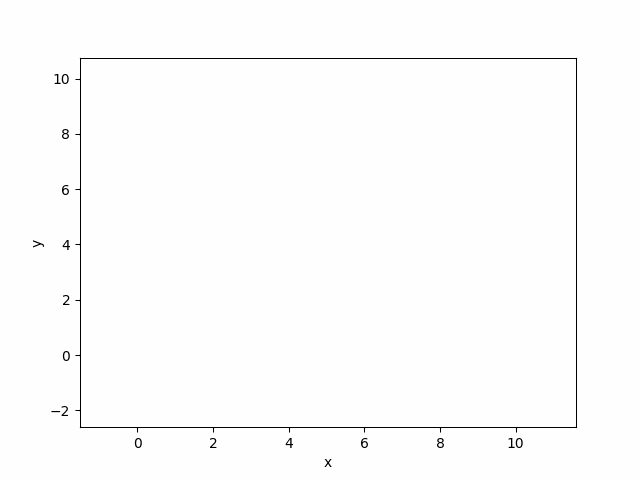

In [75]:
# DEBUG:
sections = [
    ((0.07575757575757569, 0.14069264069264054), (9.978354978354979, 1.8181818181818183)),
    ((0.07575757575757569, 0.14069264069264054), (10, -1)),
    ((5.595238095238096, 0.6006493506493507), (8.814935064935067, 0.49242424242424243)),
    ((0.8603896103896105, 2.061688311688312), (7.353896103896106, 1.8722943722943723)),
    ((1.7532467532467537, 2.4945887445887447), (9.220779220779221, 4.253246753246754)),
    ((3.1060606060606064, 2.4404761904761907), (9.491341991341994, 2.4404761904761907)),
    ((0.4816017316017316, 3.2521645021645025), (4.2153679653679665, 9.150432900432902)),
    ((1.212121212121212, 8.474025974025976), (2.267316017316018, 7.148268398268399)),
    ((3.8906926406926416, 6.336580086580088), (8.165584415584416, 5.037878787878788)),
    ((4.485930735930737, 4.496753246753247), (7.624458874458875, 4.604978354978355)),
    ((5.676406926406927, 6.796536796536797), (8.67965367965368, 8.636363636363637)),
]
p = (7.7, 5.5)

result, vis = build_trapezoidal_map_visualization(sections, seed=int(time.time()))
found_trap = result.find(p).trapezoid
print(sections)
print(found_trap.__dict__)

vis.add_point(p, color="purple")
vis.add_point(found_trap.as_verticies(sections), color="red")
vis.show_gif(interval=500)

## Bibliografia
 - Mark de Berg, Otfried Cheong, Marc van Kreveld, Mark Overmars. (1997) *Computational Geometry*, Springer. 
   - <sup>1</sup>(p. 137-139), <sup>2</sup>(p. 129), <sup>3</sup>(p. 133-136),